In [1]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving student-mat.csv to student-mat.csv
User uploaded file "student-mat.csv" with length 56993 bytes


In [2]:
import pandas as pd
import numpy as np 

raw_csv = pd.read_csv('student-mat.csv',sep=';')
raw_csv = raw_csv.drop(['address','sex','famsize'],axis=1)

In [3]:
print(raw_csv.describe())

              age        Medu        Fedu  ...          G1          G2          G3
count  395.000000  395.000000  395.000000  ...  395.000000  395.000000  395.000000
mean    16.696203    2.749367    2.521519  ...   10.908861   10.713924   10.415190
std      1.276043    1.094735    1.088201  ...    3.319195    3.761505    4.581443
min     15.000000    0.000000    0.000000  ...    3.000000    0.000000    0.000000
25%     16.000000    2.000000    2.000000  ...    8.000000    9.000000    8.000000
50%     17.000000    3.000000    2.000000  ...   11.000000   11.000000   11.000000
75%     18.000000    4.000000    3.000000  ...   13.000000   13.000000   14.000000
max     22.000000    4.000000    4.000000  ...   19.000000   19.000000   20.000000

[8 rows x 16 columns]


In [4]:
object_col = raw_csv.select_dtypes(['object']).columns #exclude numeric columns
prep = raw_csv
for col in object_col:
  prep = pd.get_dummies(prep,columns =[col])

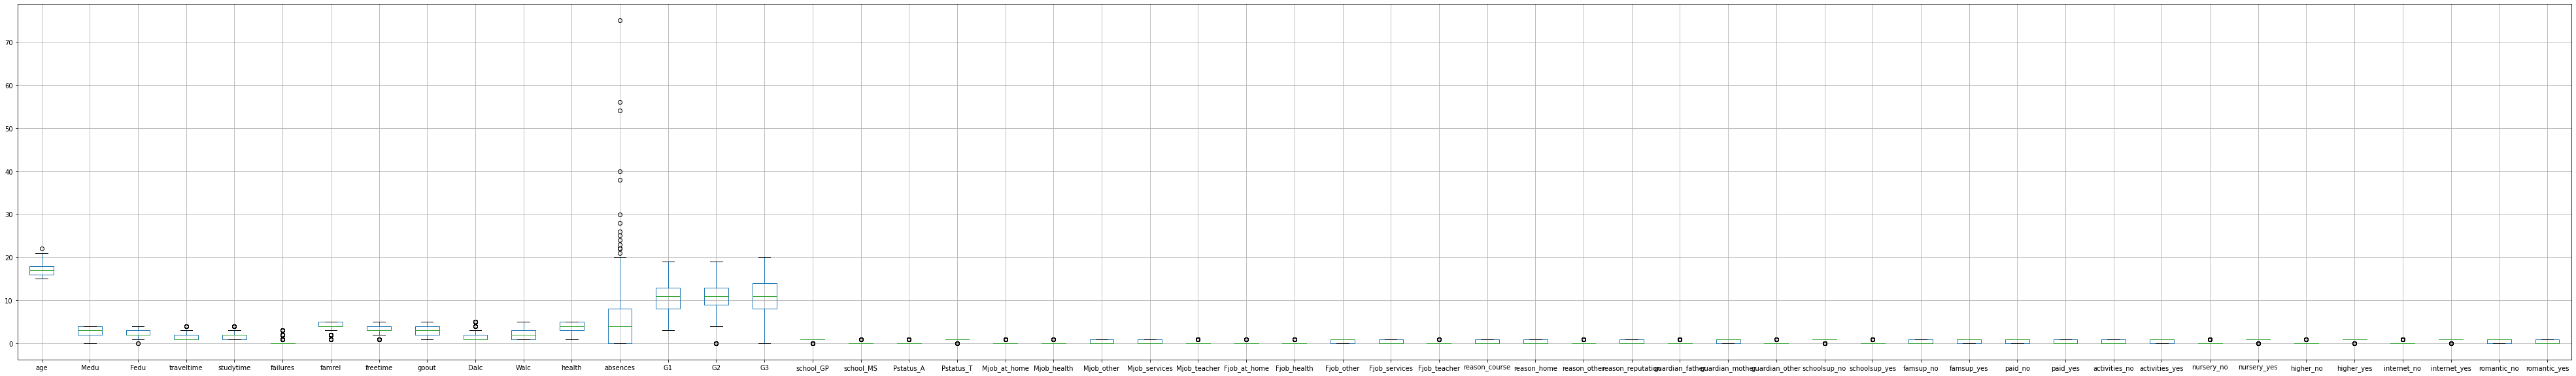

In [5]:
prep.boxplot(figsize=(70,10))

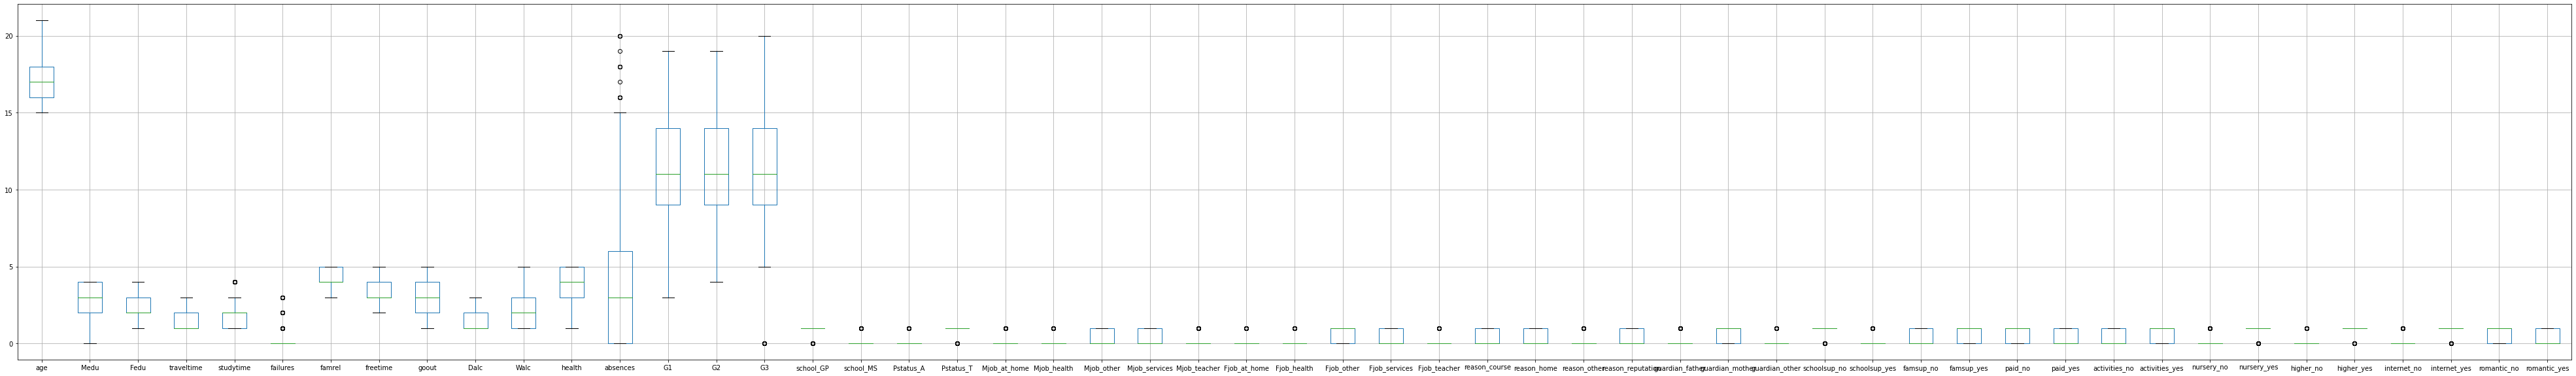

In [6]:
numeric = prep.select_dtypes(exclude=['uint8']).drop(['studytime','failures'],axis=1)
#exclude *studytime, *failures, one-hot features 

Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3 - Q1    

outlier_rm =  numeric[((numeric >= (Q1 - 1.5 * IQR)) & (numeric <= (Q3 + 1.5 * IQR))).all(axis=1)]

prep[numeric.columns] = outlier_rm[numeric.columns]

prep = prep.dropna()

prep.boxplot(figsize=(70,10))

In [7]:
numeric = prep.select_dtypes(exclude=['uint8'])  #exclude one-hot features

Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3 - Q1    

outlier_rm = numeric[(numeric >= (Q1 - 1.5 * IQR)) & (numeric <= (Q3 + 1.5 * IQR))]
prep[numeric.columns] = outlier_rm[numeric.columns]
prep
#prep.boxplot(figsize=(70,10))

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18.0,4.0,4.0,2.0,2.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,6.0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17.0,1.0,1.0,1.0,2.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,6.0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15.0,1.0,1.0,1.0,2.0,NaN,4.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,10.0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,15.0,4.0,2.0,1.0,3.0,0.0,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,15.0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,16.0,3.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,10.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,19.0,2.0,3.0,1.0,3.0,NaN,5.0,4.0,2.0,1.0,2.0,5.0,0.0,7.0,5.0,NaN,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0
388,18.0,3.0,1.0,1.0,2.0,0.0,4.0,3.0,4.0,1.0,1.0,1.0,0.0,7.0,9.0,8.0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0
392,21.0,1.0,1.0,1.0,1.0,NaN,5.0,5.0,3.0,3.0,3.0,3.0,3.0,10.0,8.0,7.0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0
393,18.0,3.0,2.0,3.0,1.0,0.0,4.0,4.0,1.0,3.0,4.0,5.0,0.0,11.0,12.0,10.0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0


In [8]:
choose = prep['traveltime'].sample(5).index
prep.loc[choose,'traveltime'] = np.nan

In [9]:
#Check the result by displaying the data.
prep[prep['traveltime'].isnull()]

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
93,16.0,4.0,2.0,NaN,2.0,0.0,5.0,3.0,3.0,1.0,1.0,1.0,0.0,11.0,10.0,10.0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0
193,16.0,3.0,3.0,NaN,1.0,0.0,4.0,3.0,2.0,3.0,4.0,5.0,8.0,8.0,9.0,10.0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
279,18.0,4.0,3.0,NaN,1.0,0.0,4.0,2.0,3.0,1.0,2.0,1.0,8.0,10.0,11.0,10.0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0
285,17.0,1.0,1.0,NaN,2.0,0.0,4.0,3.0,3.0,1.0,2.0,4.0,2.0,12.0,10.0,11.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0
323,17.0,3.0,1.0,NaN,3.0,0.0,3.0,4.0,3.0,2.0,3.0,5.0,1.0,12.0,14.0,15.0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0


In [10]:
#prep.interpolate(mehotd='linear', limit_direction='forward')
prep_intp = prep.interpolate(method='linear')

In [28]:
#Check the result by displaying the data.
prep_intp[prep_intp['traveltime'].isnull()]

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes


In [13]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(prep_intp.drop(['G1','G2','G3'], axis=1),prep_intp['G3'],test_size = 0.2)

In [14]:
import torch
import torchvision            
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [15]:
MODEL_NAME = 'MLP'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = MLP, DEVICE = cpu


In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, nodes):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(           
           
            nn.Linear(input_size, int(nodes/2)),             
            nn.ReLU(),                     
            
          
            nn.Linear(int(nodes/2), nodes),              
            nn.ReLU(),                     
            
            nn.Linear(nodes, nodes),              
            nn.ReLU(),                       

          
            nn.Linear(nodes, num_classes),
              
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)          
        y_ = self.mlp(y_)                   
        return y_

In [17]:
X_train_tensor = torch.Tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.Tensor(X_test.values.astype(np.float32))

y_train_tensor = torch.Tensor(y_train.values.astype(np.int))
y_test_tensor = torch.Tensor(y_test.values.astype(np.int))

In [18]:
  batch_size = 32
  train_set = TensorDataset(X_train_tensor,y_train_tensor)
  test_set = TensorDataset(X_test_tensor,y_test_tensor)
  train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)
  test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)

In [19]:
model =MLP(len(X_train.columns),21,32).to(DEVICE)

In [20]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [21]:

loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:

all_losses = []

In [23]:
max_epoch = 500   
step = 0           

plot_every = 200
total_loss = 0

start = time.time()

for epoch in range(max_epoch):
    for idx, (students, target) in enumerate(train_loader):

     
        x, y = students.to(DEVICE), target.to(DEVICE)

        y_hat = model(x)       
       
        loss = loss_fn(y_hat, y.long())   
        total_loss += loss.item()
        
        optim.zero_grad()         
        loss.backward()           
        optim.step()              
        
       
        if step % 50 == 0:
            print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)  
            total_loss = 0
        
     
        if step % 200 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():   
                for idx,  (students, target) in enumerate(test_loader):
                    x, y = students.to(DEVICE), target.to(DEVICE)
                    y_hat = model(x) 
                    loss = loss_fn(y_hat, y.long())
                    _, indices = torch.max(y_hat, dim=-1)     
                                                           
                    acc += torch.sum(indices == y).item()   
                                                             
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, test accuracy: {} %'.format(step, loss.item(), acc/len(y_test)*100))
            print('*'*46)
            model.train()          
        step += 1

Epoch(0m 0s): 0/500, Step: 0, Loss: 3.023474931716919
******************** Test ********************
Step: 0, Loss: 2.994879961013794, test accuracy: 9.67741935483871 %
**********************************************
Epoch(0m 0s): 7/500, Step: 50, Loss: 2.641951084136963
Epoch(0m 0s): 14/500, Step: 100, Loss: 2.556755542755127
Epoch(0m 0s): 21/500, Step: 150, Loss: 2.4237260818481445
Epoch(0m 0s): 28/500, Step: 200, Loss: 2.4038078784942627
******************** Test ********************
Step: 200, Loss: 2.512749195098877, test accuracy: 19.35483870967742 %
**********************************************
Epoch(0m 0s): 35/500, Step: 250, Loss: 2.5742154121398926
Epoch(0m 0s): 42/500, Step: 300, Loss: 2.38826584815979
Epoch(0m 0s): 50/500, Step: 350, Loss: 2.449735403060913
Epoch(0m 0s): 57/500, Step: 400, Loss: 2.3649890422821045
******************** Test ********************
Step: 400, Loss: 2.465369701385498, test accuracy: 22.58064516129032 %
********************************************

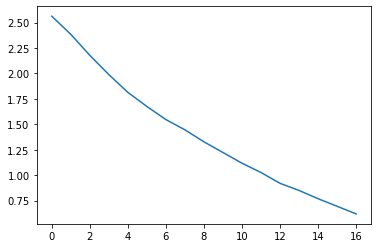

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [25]:
batches = [8,16,32,64]
nodes = [16,32,64,128]

In [26]:
for node in nodes:
 model =MLP(len(X_train.columns),21,node).to(DEVICE) 



 for batch_size in batches:
  train_set = TensorDataset(X_train_tensor,y_train_tensor)
  test_set = TensorDataset(X_test_tensor,y_test_tensor)
  train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)
  test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=False, drop_last=False)
  # reset loss history
  loss_fn = nn.CrossEntropyLoss()
  optim = torch.optim.Adam(model.parameters(), lr=0.001)
  all_losses = []


  max_epoch = 200      # maximum number of epochs
  step = 0             # initialize step counter variable

  plot_every = 200 
  total_loss = 0 # Reset every plot_every iters

  print('batch = ', batch_size, 'node = ', node)
  start = time.time()

  for epoch in range(max_epoch):
     for idx, (students, target) in enumerate(train_loader):

          #x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
         x, y = students.to(DEVICE), target.to(DEVICE)

         y_hat = model(x)            # forward propagation, y_hat.shape = (N, 10) 
       
         loss = loss_fn(y_hat, y.long())    # computing loss
         total_loss += loss.item()
        
         optim.zero_grad()           # reset gradient
         loss.backward()             # back-propagation (compute gradient)
         optim.step()                # update parameters with gradient
        
        # periodically print loss
         if step % 500 == 0:
              print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
         if (step + 1) % plot_every == 0:
             all_losses.append(total_loss / plot_every)  #loss값들 리스트에 쌓여감 나중에 plt.plot에 넣어서 표시
             total_loss = 0
        
        # periodically evalute model on test data
         if step % 1000 == 0:
             model.eval()
             acc = 0.
             with torch.no_grad():   # disable autograd
                  for idx,  (students, target) in enumerate(test_loader):
                     x, y = students.to(DEVICE), target.to(DEVICE) # (N, 1, 28, 28), (N, )
                     y_hat = model(x) # (N, 10)
                     loss = loss_fn(y_hat, y.long())
                     _, indices = torch.max(y_hat, dim=-1)     # find maxmum along the last axis (argmax of each row)
                                                              # ex) max_value, max_idx = torch.max(input, dim)
                     acc += torch.sum(indices == y).item()     # count correctly classified samples
                                                              # torch.sum() returns Tensor. Tensor.item() converts it to a value
             print('*'*20, 'Test', '*'*20)
             print('Step: {}, Loss: {}, test accuracy: {} %'.format(step, loss.item(), acc/len(y_test)*100))
             print('*'*46)
             model.train()           # turn to train mode (enable autograd)
         step += 1

